# Eksperyment A/B

Załaduj biblioteki, moduły i pliki ze zbiorami testowymi

In [31]:
import requests
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score
from scipy import stats
import json
from numpy import var
import matplotlib.pyplot as plt

from model_creation import load_and_preprocess_data

all_metrics = []

X_test = load_and_preprocess_data('content/custom_data/X_test.csv')
Y_test = load_and_preprocess_data('content/custom_data/Y_test.csv')

def plot_pvalue_changes(base, advanced):
	shapiro_p_values = []
	levene_p_values = []
	ttest_p_values = []

	for i in range(3, len(base) + 1):
		base_sample = base[:i]
		advanced_sample = advanced[:i]

		_, shapiro_p_base = stats.shapiro(base_sample)
		_, shapiro_p_adv = stats.shapiro(advanced_sample)
		shapiro_p_values.append((shapiro_p_base, shapiro_p_adv))

		_, levene_p = stats.levene(base_sample, advanced_sample)
		levene_p_values.append(levene_p)

		_, ttest_p = stats.ttest_ind(base_sample, advanced_sample, equal_var=True)
		ttest_p_values.append(ttest_p)

	x = range(3, len(base) + 1)
	shapiro_base_p, shapiro_adv_p = zip(*shapiro_p_values)

	plt.figure(figsize=(12, 8))

	plt.subplot(3, 1, 1)
	plt.plot(x, shapiro_base_p, label='Shapiro-Wilk Base', marker='o')
	plt.plot(x, shapiro_adv_p, label='Shapiro-Wilk Advanced', marker='o')
	plt.axhline(y=0.05, color='r', linestyle='--', label='p = 0.05')
	plt.title('Shapiro-Wilk Test p-values')
	plt.xlabel('Number of Samples')
	plt.ylabel('p-value')
	plt.legend()

	plt.subplot(3, 1, 2)
	plt.plot(x, levene_p_values, label='Levene Test', color='g', marker='o')
	plt.axhline(y=0.05, color='r', linestyle='--', label='p = 0.05')
	plt.title('Levene Test p-values')
	plt.xlabel('Number of Samples')
	plt.ylabel('p-value')
	plt.legend()

	plt.subplot(3, 1, 3)
	plt.plot(x, ttest_p_values, label='t-Test', color='b', marker='o')
	plt.axhline(y=0.05, color='r', linestyle='--', label='p = 0.05')
	plt.title('t-Test p-values')
	plt.xlabel('Number of Samples')
	plt.ylabel('p-value')
	plt.legend()

	plt.tight_layout()
	plt.show()

Wybierz seedy, na podstawie których będą dzielone przypadki między model A i B. By wynik był miarodajny, wykonaj kilkanaście iteracji.

Użyte seedy

In [8]:
try:
    with open('content/results/ab_results.json', 'r') as input_file:
        old_metrics = json.load(input_file)
except Exception as e:
    print(f"Error: {e}")
    old_metrics = []

used_seeds = [experiment['seed'] for experiment in old_metrics]

print(used_seeds)

[1, 2, 3, 4]


In [22]:
seeds = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

Sprawdź, czy mikroserwis jest włączony

In [23]:
try:
    requests.get("http://localhost:8080/predict")
    print("Serwis działa")
except requests.exceptions.RequestException as e:
    print("Wystąpił problem z połączeniem z serwisem")

Serwis działa


Zbierz predykcje i zapisz metryki na podstawie, których oceniane będą modele

In [24]:
for seed in seeds:
    print(f"Running test for seed: {seed}")

    X_base, X_advanced, Y_base, Y_advanced = train_test_split(X_test, Y_test, test_size=0.5, random_state=seed)
    base_dicts = X_base.to_dict(orient='records')
    advanced_dicts = X_advanced.to_dict(orient='records')

    # Make predictions for divided sets
    base_predictions = []
    for entry in tqdm(base_dicts, desc="Sending requests for predictions (Base)"):
        response = requests.post("http://localhost:8080/predict_base", json=entry)
        base_predictions.append(response.json()['base_prediction'])

    advanced_predictions = []
    for entry in tqdm(advanced_dicts, desc="Sending requests for predictions (Advanced)"):
        response = requests.post("http://localhost:8080/predict_advanced", json=entry)
        advanced_predictions.append(response.json()['advanced_prediction'])

    # Analyze results
    base_results = Y_base
    base_results["base_predictions"] = base_predictions
    advanced_results = Y_advanced
    advanced_results["advanced_predictions"] = advanced_predictions
    
    # For base model
    base_confusion_matrix = confusion_matrix(base_results['premium_user'], base_results['base_predictions'])
    base_precision = precision_score(base_results["premium_user"], base_results["base_predictions"])
    base_accuracy = accuracy_score(base_results["premium_user"], base_results["base_predictions"])
    base_f1 = f1_score(base_results["premium_user"], base_results["base_predictions"])
    
    # For advanced model
    advanced_confusion_matrix = confusion_matrix(advanced_results['premium_user'], advanced_results['advanced_predictions'])
    advanced_precision = precision_score(advanced_results["premium_user"], advanced_results["advanced_predictions"])
    advanced_accuracy = accuracy_score(advanced_results["premium_user"], advanced_results["advanced_predictions"])
    advanced_f1 = f1_score(advanced_results["premium_user"], advanced_results["advanced_predictions"])

    # Collect metrics to dictionary
    all_metrics.append({
    "seed": seed,
    "base": {
        "confusion_matrix": base_confusion_matrix.tolist(),
        "precision": round(base_precision * 100, 3),
        "accuracy": round(base_accuracy * 100, 3),
        "f1_score": round(base_f1 * 100, 3)
    },
    "advanced": {
        "confusion_matrix": advanced_confusion_matrix.tolist(),
        "precision": round(advanced_precision * 100, 3),
        "accuracy": round(advanced_accuracy * 100, 3),
        "f1_score": round(advanced_f1 * 100, 3)
    }
})

Running test for seed: 16


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]


Running test for seed: 17


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Running test for seed: 18


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]


Running test for seed: 19


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]


Running test for seed: 20


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]


Running test for seed: 21


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:07<00:00,  2.05s/it]


Running test for seed: 22


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Running test for seed: 23


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Running test for seed: 24


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Running test for seed: 25


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Running test for seed: 26


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Running test for seed: 27


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.05s/it]


Running test for seed: 28


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.05s/it]


Running test for seed: 29


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Running test for seed: 30


Sending requests for predictions (Advanced): 100%|██████████| 150/150 [05:06<00:00,  2.04s/it]


Zapisz otrzymane metryki w pliku json

In [29]:
try:
    with open('content/results/ab_results.json', 'r') as output_file:
        old_metrics = json.load(output_file)
except FileNotFoundError:
    old_metrics = []
    
old_metrics.extend(all_metrics)
    
try:
    with open('content/results/ab_results.json', 'w') as output_file:
        json.dump(old_metrics, output_file, indent=4)
except Exception as e:
    print(f"Error: {e}")

## Test t-Studenta
### Hipoteza zerowa (H0): Nie ma statystycznej różnicy między modelem zaawansowanym (las losowy) a bazowym (regresja logistyczna).
### Hipoteza alternatywna (H1): Istnieje statystyczna różnica między modelem zaawansowanym (las losowy) a bazowym (regresja logistyczna).
#### Jeśli p-value jest mniejsza od przyjętego alfa (standardowo 0.05), to znaczy, że wynik jest statystycznie istotny i możemy odrzucić hipotezę zerową.
#### Dodatkowo jeśli wartość testu t-Studenta jest ujemna to znaczy, że model bazowy uzyskuje średnio gorsze wyniki od modelu zaawansowanego.

Użyj świeżo zebranych danych

In [24]:
base_precisions = []
advanced_precisions = []

base_accuracies = []
advanced_accuracies = []

base_f1_scores = []
advanced_f1_scores = []
    
for experiment in all_metrics:
    base_precisions.append(experiment['base']['precision'])
    advanced_precisions.append(experiment['advanced']['precision'])

    base_accuracies.append(experiment['base']['accuracy'])
    advanced_accuracies.append(experiment['advanced']['accuracy'])

    base_f1_scores.append(experiment['base']['f1_score'])
    advanced_f1_scores.append(experiment['advanced']['f1_score'])

Wczytaj dane z pliku (opcjonalne)

In [12]:
try:
    with open('content/results/ab_results.json', 'r') as input_file:
        old_metrics = json.load(input_file)
except Exception as e:
    print(f"Error: {e}")
    old_metrics = [] 

base_precisions = []
advanced_precisions = []

base_accuracies = []
advanced_accuracies = []

base_f1_scores = []
advanced_f1_scores = []
    
for experiment in old_metrics:
    base_precisions.append(experiment['base']['precision'])
    advanced_precisions.append(experiment['advanced']['precision'])

    base_accuracies.append(experiment['base']['accuracy'])
    advanced_accuracies.append(experiment['advanced']['accuracy'])

    base_f1_scores.append(experiment['base']['f1_score'])
    advanced_f1_scores.append(experiment['advanced']['f1_score'])


Sprawdźmy warunki początkowe: próby A i B mają być niezależne - zgadza się, w każdej iteracji zbiory testowe są rozłączne, rozkład zmiennych ma być normalny - przeprowadzimy test Shapiro-Wilka, by to sprawdić, wariancje mają być podobne - sprawdzimy to testem Levene'a. 

Test Shapiro-Wilka

In [14]:
shapiro_base_precision = stats.shapiro(base_precisions)
shapiro_advanced_precision = stats.shapiro(advanced_precisions)

shapiro_base_accuracy = stats.shapiro(base_accuracies)
shapiro_advanced_accuracy = stats.shapiro(advanced_accuracies)

shapiro_base_f1 = stats.shapiro(base_f1_scores)
shapiro_advanced_f1 = stats.shapiro(advanced_f1_scores)

print(shapiro_base_precision)
print(shapiro_advanced_precision)

print(shapiro_base_accuracy)
print(shapiro_advanced_accuracy)

print(shapiro_base_f1)
print(shapiro_advanced_f1)

if shapiro_base_precision.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład precyzji modelu bazowego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład precyzji modelu bazowego nie jest normalny.")
if shapiro_advanced_precision.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład precyzji modelu zaawansowanego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład precyzji modelu zaawansowanego nie jest normalny.")

if shapiro_base_accuracy.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład dokładności modelu bazowego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład dokładności modelu bazowego nie jest normalny.")
if shapiro_advanced_accuracy.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład dokładności modelu zaawansowanego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład dokładności modelu zaawansowanego nie jest normalny.")

if shapiro_base_f1.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład F1-Score modelu bazowego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład F1-Score modelu bazowego nie jest normalny.")
if shapiro_advanced_f1.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład F1-Score modelu zaawansowanego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład F1-Score modelu zaawansowanego nie jest normalny.")


ShapiroResult(statistic=np.float64(0.9770801479041471), pvalue=np.float64(0.743756988302114))
ShapiroResult(statistic=np.float64(0.9839509739957797), pvalue=np.float64(0.9180103908954356))
ShapiroResult(statistic=np.float64(0.9811166426444752), pvalue=np.float64(0.8544094768211481))
ShapiroResult(statistic=np.float64(0.9676612749304485), pvalue=np.float64(0.47732689141187506))
ShapiroResult(statistic=np.float64(0.9743951388272057), pvalue=np.float64(0.6649143031409243))
ShapiroResult(statistic=np.float64(0.9829761652290019), pvalue=np.float64(0.8979375687137547))
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład precyzji modelu bazowego jest normalny.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład precyzji modelu zaawansowanego jest normalny.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład dokładności modelu bazowego jest normalny.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład dokładności modelu zaawansowanego jes

Test Levene'a

In [15]:
precision_levene, precision_p = stats.levene(base_precisions, advanced_precisions)

accuracy_levene, accuracy_p = stats.levene(base_accuracies, advanced_accuracies)

f1_levene, f1_p = stats.levene(base_f1_scores, advanced_f1_scores)

print(precision_levene, precision_p)

print(accuracy_levene, accuracy_p)

print(f1_levene, f1_p)

if precision_p >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje precyzji modelu bazowego i zaawansowanego są podobne.")
else:
	print("Istnieją podstawy do twierdzenia, że wariancje precyzji modelu bazowego i zaawansowanego nie są podobne.")

if accuracy_p >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje dokładności modelu bazowego i zaawansowanego są podobne.")
else:
	print("Istnieją podstawy do twierdzenia, że wariancje dokładności modelu bazowego i zaawansowanego nie są podobne.")

if f1_p >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje F1-Score modelu bazowego i zaawansowanego są podobne.")
else:
	print("Istnieją podstawy do twierdzenia, że wariancje F1-Score modelu bazowego i zaawansowanego nie są podobne.")


0.41846661832386317 0.520255135565127
0.5879675552125773 0.4463161166123085
1.1964768115818256 0.2785491037347206
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje precyzji modelu bazowego i zaawansowanego są podobne.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje dokładności modelu bazowego i zaawansowanego są podobne.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje F1-Score modelu bazowego i zaawansowanego są podobne.


Przeprowadź test t-Studenta

In [16]:
alpha = 0.05

t_stat_precision, p_value_precision = stats.ttest_ind(advanced_precisions, base_precisions)
t_stat_accuracy, p_value_accuracy = stats.ttest_ind(advanced_accuracies, base_accuracies)
t_stat_f1, p_value_f1 = stats.ttest_ind(advanced_f1_scores, base_f1_scores)

print(f"Test t-Studenta dla precyzji: t-statistic = {t_stat_precision}, p-value = {p_value_precision}")
print(f"Test t-Studenta dla dokładności: t-statistic = {t_stat_accuracy}, p-value = {p_value_accuracy}")
print(f"Test t-Studenta dla F1-Score: t-statistic = {t_stat_f1}, p-value = {p_value_f1}")

if p_value_precision < alpha:
    print("Różnica w precyzji jest statystycznie istotna")
    if t_stat_precision > 0:
        print("Model zaawansowany ma lepszą precyzję")
    elif t_stat_precision < 0:
        print("Model zaawansowany ma gorszą precyzję")
else:
    print("Różnica w precyzji nie jest statystycznie istotna")

if p_value_accuracy < alpha:
    print("Różnica w dokładności jest statystycznie istotna")
    if t_stat_accuracy > 0:
        print("Model zaawansowany ma lepszą dokładność")
    elif t_stat_accuracy < 0:
        print("Model zaawansowany ma gorszą dokładność")
else:
    print("Różnica w dokładności nie jest statystycznie istotna")

if p_value_f1 < alpha:
    print("Różnica w F1-Score jest statystycznie istotna")
    if t_stat_f1 > 0:
        print("Model zaawansowany ma lepszy F1-Score")
    elif t_stat_f1 < 0:
        print("Model zaawansowany ma gorszy F1-Score")
else:
    print("Różnica w F1-Score nie jest statystycznie istotna")

Test t-Studenta dla precyzji: t-statistic = 1.7182517779902946, p-value = 0.0910852488076721
Test t-Studenta dla dokładności: t-statistic = 12.616212375918076, p-value = 2.854363502636286e-18
Test t-Studenta dla F1-Score: t-statistic = 16.31587822782098, p-value = 2.42728254897345e-23
Różnica w precyzji nie jest statystycznie istotna
Różnica w dokładności jest statystycznie istotna
Model zaawansowany ma lepszą dokładność
Różnica w F1-Score jest statystycznie istotna
Model zaawansowany ma lepszy F1-Score


Tak zmieniały się p-values przy dobieraniu kolejnych próbek

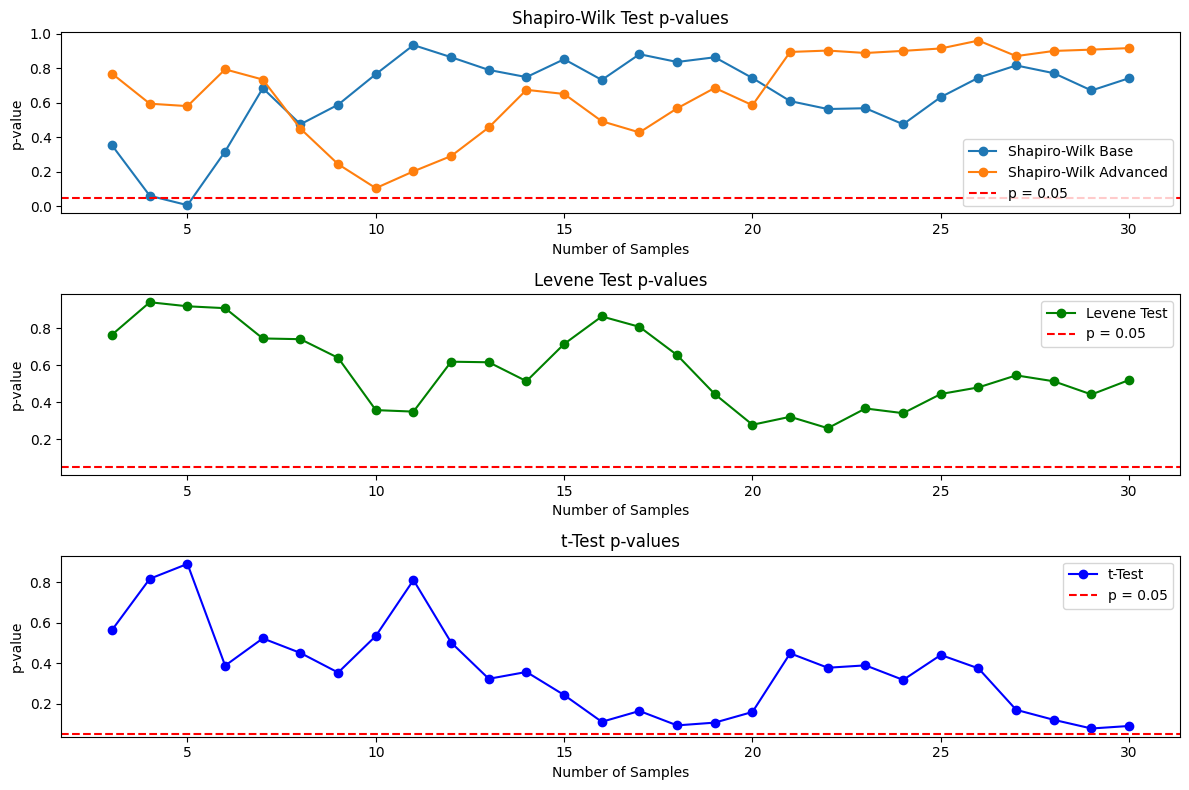

In [32]:
plot_pvalue_changes(base_precisions, advanced_precisions)
plot_pvalue_changes(base_accuracies, advanced_accuracies)
plot_pvalue_changes(base_accuracies, advanced_accuracies)